# Obtain company embedding from descriptive feaatures

In [11]:
import os
import pandas as pd
import numpy as np
import gensim.downloader as api
import logging
logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.parsing.preprocessing import preprocess_documents, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, preprocess_string
pcwd = os.getcwd()


In [2]:
# Only load once
glove = api.load("glove-wiki-gigaword-100")

2019-11-01 00:51:54,850 : MainThread : INFO : loading projection weights from /Users/lelecao/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz
2019-11-01 00:52:40,044 : MainThread : INFO : loaded (400000, 100) matrix from /Users/lelecao/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz


## Prepare sentence embedding training data

In [27]:
# df = pd.read_json(os.path.join(pcwd, '../data/org_snapshot.json'), lines = True) # for dev
df = pd.read_json(os.path.join(pcwd, '../data/org.json'), lines = True)
df = df[['company_name', 'short_description', 'description']] # note that no short_description is null
df = df.replace(np.nan, '', regex=True)
df['org_desc'] = df.company_name + ' MYSEP ' + df.short_description + ' MYSEP ' + df.description
df_list = df['org_desc'].tolist()
print(df_list[:2])

['BN Media MYSEP BN Media is an entity that features three cross promoted faith and inspiration brands including Affinity4, Beliefnet, and Cross Bridge. MYSEP The mission of BN Media is to serve the vast online market for spirituality and inspiration, bringing audio-visual and written content to the masses while helping people make a difference for their favorite nonprofit organization. BN Media achieves this by bridging the gap through which ordinary activities inspire activism, online giving, and volunteerism.']


In [28]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, 
                  strip_multiple_whitespaces, strip_numeric, remove_stopwords]
df_list_processed = []
for s in df_list:
    df_list_processed.append(preprocess_string(s, CUSTOM_FILTERS))
print(df_list_processed[:2])


[['bn', 'media', 'mysep', 'bn', 'media', 'entity', 'features', 'cross', 'promoted', 'faith', 'inspiration', 'brands', 'including', 'affinity', 'beliefnet', 'cross', 'bridge', 'mysep', 'mission', 'bn', 'media', 'serve', 'vast', 'online', 'market', 'spirituality', 'inspiration', 'bringing', 'audio', 'visual', 'written', 'content', 'masses', 'helping', 'people', 'difference', 'favorite', 'nonprofit', 'organization', 'bn', 'media', 'achieves', 'bridging', 'gap', 'ordinary', 'activities', 'inspire', 'activism', 'online', 'giving', 'volunteerism'], ['bsn', 'glasspack', 'mysep', 'second', 'largest', 'glass', 'container', 'maker', 'europe', 'mysep']]


## Finetune the word embedding

In [29]:
# Format training dataset
from fse import IndexedList
s = IndexedList(df_list_processed)
print(len(s))
# s.items

803824


In [30]:
# Train!
from fse.models.average import FAST_VERSION, MAX_WORDS_IN_BATCH
print(MAX_WORDS_IN_BATCH, FAST_VERSION)
from fse.models import SIF
model = SIF(glove, workers=2)
model.train(s)

2019-11-01 01:04:53,281 : MainThread : INFO : scanning all indexed sentences and their word counts


10000 1


2019-11-01 01:04:54,553 : MainThread : INFO : finished scanning 803824 sentences with an average length of 45 and 36757869 total words
2019-11-01 01:04:55,163 : MainThread : INFO : estimated memory for 803824 sentences with 100 dimensions and 400000 vocabulary: 460 MB (0 GB)
2019-11-01 01:04:55,164 : MainThread : INFO : initializing sentence vectors for 803824 sentences
2019-11-01 01:04:58,084 : MainThread : INFO : pre-computing SIF weights for 400000 words
2019-11-01 01:04:58,320 : MainThread : INFO : begin training
2019-11-01 01:05:03,329 : MainThread : INFO : PROGRESS : finished 43.39% with 348751 sentences and 14394215 words, 69750 sentences/s
2019-11-01 01:05:08,330 : MainThread : INFO : PROGRESS : finished 89.22% with 717161 sentences and 29623624 words, 73682 sentences/s
2019-11-01 01:05:09,581 : MainThread : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-01 01:05:09,582 : MainThread : INFO : worker thread finished; awaiting finish of 0 more threads
201

(803824, 33212773)

## Model qualitative healthchecks

In [32]:
# Prediction health-check
tmp = ("service auto mobile lagacy".split(), 0)
print(model.infer([tmp]))

2019-11-01 01:05:27,360 : MainThread : INFO : scanning all indexed sentences and their word counts
2019-11-01 01:05:27,360 : MainThread : INFO : finished scanning 1 sentences with an average length of 4 and 4 total words
2019-11-01 01:05:27,362 : MainThread : INFO : removing 1 principal components took 0s


[[-9.67704803e-02 -2.14988783e-01  7.35461712e-04 -2.93098874e-02
  -6.57490641e-02 -4.01099831e-01  6.55035973e-02  4.15836237e-02
   2.77396888e-01 -2.84801126e-02 -6.47550523e-02 -1.02001667e-01
  -3.33081692e-01 -7.23675638e-02 -8.48945379e-02 -1.33705765e-01
   4.77036864e-01 -1.20317981e-01  1.41491592e-01 -4.03168947e-02
   3.10089946e-01 -1.13721281e-01  8.89803320e-02  4.27677304e-01
   4.48483527e-01 -2.64512122e-01 -1.96852446e-01  3.21999252e-01
   2.63669878e-01  2.18079641e-01  9.16420370e-02 -7.44423270e-02
   8.67591202e-02 -2.09676832e-01  3.04702759e-01  1.59409896e-01
  -2.69459605e-01 -2.31750891e-01  5.08358359e-01  2.35253334e-01
   6.42454863e-01 -1.01816565e-01  1.29749283e-01  1.74977273e-01
  -1.63949281e-03  1.51619375e-01  2.07953140e-01  7.48990923e-02
   4.93573278e-01 -1.38130635e-01 -3.55648510e-02  1.07368842e-01
  -2.48761714e-01 -3.90820086e-01  1.68352738e-01  4.76803184e-01
  -3.18808287e-01  1.72007293e-01  5.10978699e-01  2.76891172e-01
   2.63804

In [54]:
# Similarity healthcheck
print(s[9])
print(s[5])
print(model.sv.similarity(9,5).round(3))
print(s[1])
print(s[4])
print(model.sv.similarity(1,4).round(3))

(['mckonly', 'asbury', 'mysep', 'mckonly', 'asbury', 'certified', 'public', 'accounting', 'firm', 'mysep'], 9)
(['fastgrowth', 'company', 'mysep', 'demand', 'sales', 'consulting', 'services', 'company', 'mysep'], 5)
0.303
(['bsn', 'glasspack', 'mysep', 'second', 'largest', 'glass', 'container', 'maker', 'europe', 'mysep'], 1)
(['factorprism', 'mysep', 'makers', 'revolutionary', 'smart', 'data', 'discovery', 'software', 'factorprism', 'mysep'], 4)
0.031


### TSNE Visualization

In [102]:
z = model.sv.vectors
idx = np.random.choice(z.shape[0], 1000, replace=False)
z = z[idx, :]
distance = []
print('center sentence: {}'.format(df_list[4]))
for entry in idx:
    distance.append((entry, model.sv.similarity(4, entry)))

center sentence: FactorPrism MYSEP Makers of revolutionary Smart Data Discovery software FactorPrism MYSEP 


In [103]:
dist_sort = sorted(distance, key=lambda x: x[1])
print('Top 3 relatives:')
for i in range(3):
    entry = dist_sort[-(i+1)]
    print('No.{}-(dist={}): {}'.format(i, entry[-1], df_list[entry[0]]))

print('\n3 least-alike companies:')
for i in range(3):
    entry = dist_sort[i]
    print('No.{}-(dist={}): {}'.format(i, entry[-1], df_list[entry[0]]))

Top 3 relatives:
No.0-(dist=0.6211919784545898): 945signals MYSEP 945signals is a researcher and developer of intelligent search, Data/Web mining and big data solutions. MYSEP 945signals is a researcher and developer of intelligent search, Data/Web mining and big data solutions. We’ve been breathing search technologies, data mining, linked data and big data solutions for 2 years now. Semantic Search is our core focus. Our intelligent Products and solutions empower consumer and business.
No.1-(dist=0.5759040117263794): Signum Software MYSEP Software company specialized in .Net data-driven applications MYSEP 
No.2-(dist=0.5523853302001953): AMZ Insight MYSEP AMZ Insight is an intelligent web-based software for research and development for Amazon sellers. MYSEP AMZ Insight is an intelligent web-based software for research and development for Amazon sellers. Our market research tool for Amazon is the only companion sellers need for profitable selling. We aim to empower Amazon sellers to ma

In [104]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_res = tsne.fit_transform(z)
res_pd = pd.DataFrame(tsne_res)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.476141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.324448
[t-SNE] KL divergence after 1000 iterations: 1.873697


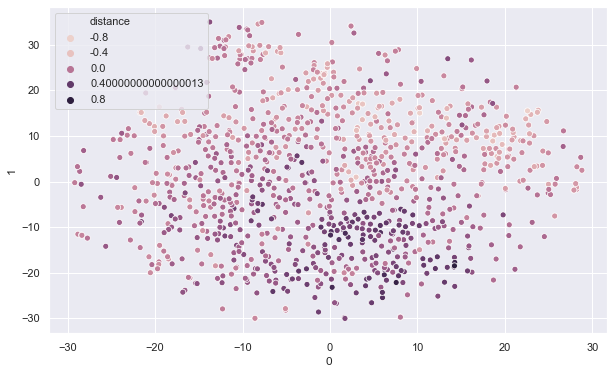

In [105]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
res_pd['distance'] = [x[1] for x in distance]
res_pd
ax = sns.scatterplot(x=0, y=1, hue="distance", data=res_pd)